### venv location:
activate the following: `~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

In [1]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils
from finetuning_utils import FinetunedEsmModel
import eval_utils
from eval_utils import CryptoBenchClassifier

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_PATH = f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model.pt'
# model = torch.load(MODEL_PATH, weights_only=False)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [2]:
SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False) #, map_location=torch.device('cpu'))

In [3]:
PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.8

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)
    print(protein_id, 'number of clusters:', len(np.unique(clusters)) - (1 if -1 in clusters else 0))
    # enhance predicted pockets using the smoothing model
    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 

        # # TODO: This is weird, fix later
        # if embeddings.shape[0] == 0:
        #     predicted_binding_sites[protein_id].append((cluster_residue_indices, 'finetuned model with smoothing'))
        #     continue

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)

        # # TODO: This is weird, fix later
        # if indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD].shape[0] == 0:
        #     predicted_binding_sites[protein_id].append((cluster_residue_indices, 'finetuned model with smoothing'))
        #     continue
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        predicted_binding_sites[protein_id].append((enhanced_residue_indices, 'finetuned model with smoothing'))

# import numpy as np
# for protein_id in prediction_scores.keys():
#     np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

1a52_A number of clusters: 4
1a5h_D number of clusters: 1
1a9w_B number of clusters: 0
1ags_B number of clusters: 3
1aii_A number of clusters: 0
1au1_A number of clusters: 0
1aue_B number of clusters: 1
1aye_A number of clusters: 2
1b1c_A number of clusters: 1
1b50_B number of clusters: 0
1b55_B number of clusters: 0
1b6c_F number of clusters: 2
1b9o_A number of clusters: 2
1bbo_A number of clusters: 0
1bci_A number of clusters: 0
1bf9_A number of clusters: 0
1bhi_A number of clusters: 0
1bhx_C number of clusters: 1
1bld_A number of clusters: 3
1blx_A number of clusters: 2
1bmo_A number of clusters: 0
1bnl_A number of clusters: 0
1boy_A number of clusters: 0
1bp5_A number of clusters: 2
1buv_A number of clusters: 3
1byg_A number of clusters: 2
1bzs_A number of clusters: 3
1c07_A number of clusters: 4
1c4z_A number of clusters: 0
1c5n_A number of clusters: 0
1c9y_A number of clusters: 3
1cb6_A number of clusters: 2
1cjy_B number of clusters: 2
1cm8_A number of clusters: 1
1cr8_A number 

In [ ]:
import pickle

for protein_id in sequences.keys():
    filename = protein_id.replace('_','')
    
    with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
        pickle.dump(predicted_binding_sites[protein_id], f)


0.12483319179910227 0.31578308868130534


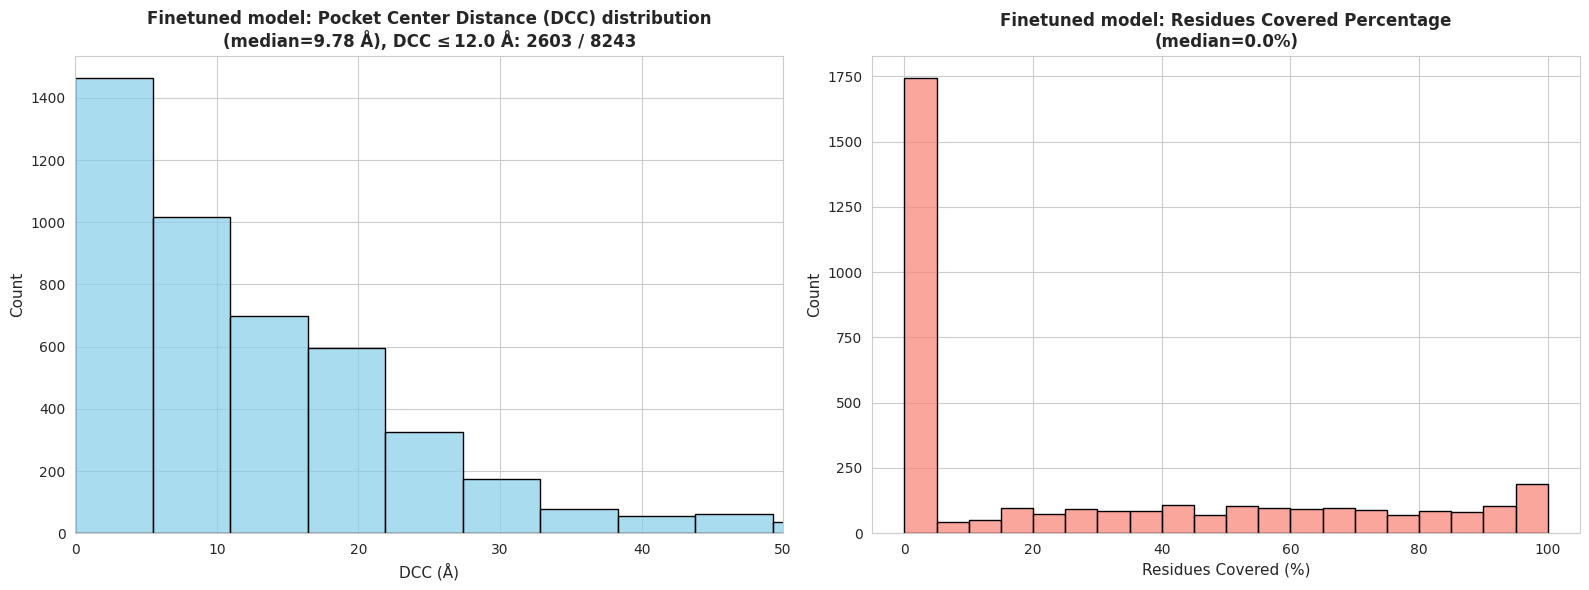

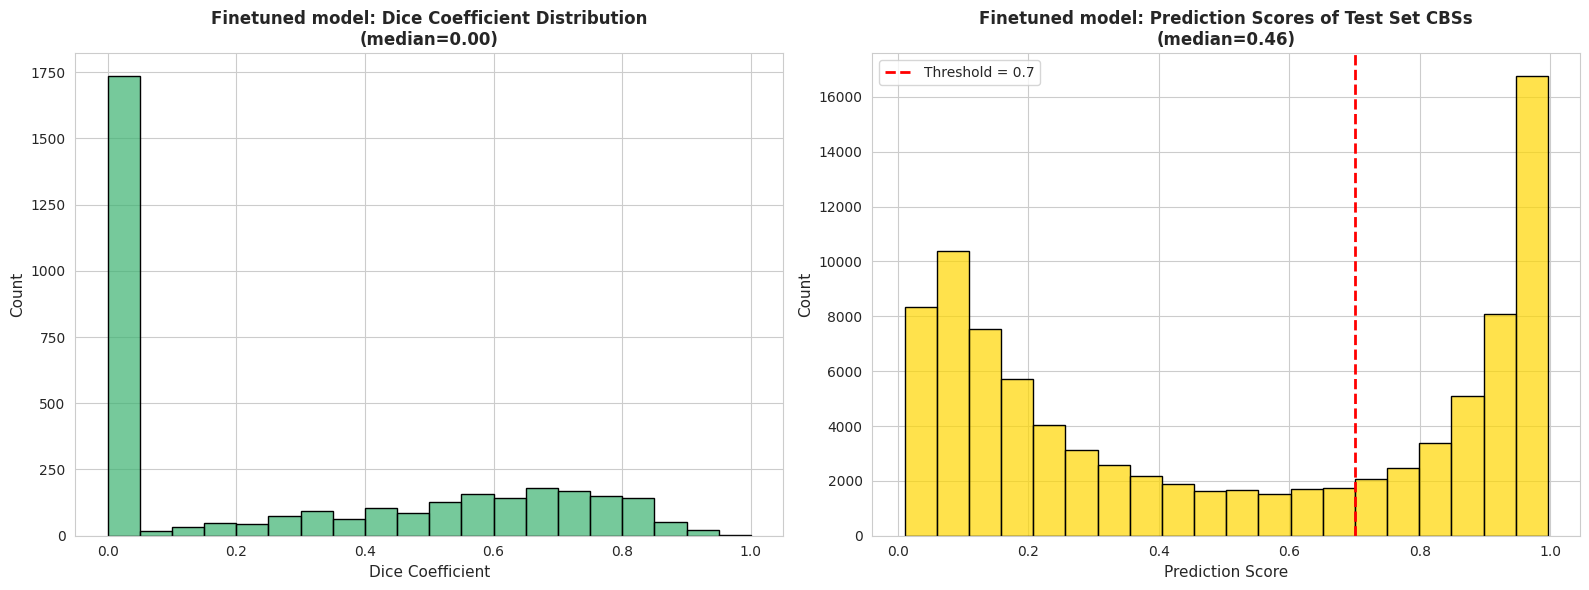

In [ ]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)
# scPDB-smoother (SMOOTHING_DECISION_THRESHOLD=0.4, eps=4, minsamples=1): 0.08103845687249787 0.44498362246754825
# scPDB-smoother (SMOOTHING_DECISION_THRESHOLD=0.8, eps=4, minsamples=1): 
# smoother.pt (SMOOTHING_DECISION_THRESHOLD=0.4, eps=4, minsamples=1): 0.1733592138784423 0.41356302317117555
# smoother.pt (SMOOTHING_DECISION_THRESHOLD=0.4, eps=4, minsamples=1): 0.1733592138784423 0.41356302317117555
# smoother.pt (SMOOTHING_DECISION_THRESHOLD=0.8, eps=5, minsamples=3): 0.12167900036394516 0.3161470338469004
# smoother.pt (SMOOTHING_DECISION_THRESHOLD=0.4, eps=5, minsamples=3): 0.12483319179910227 0.31578308868130534


# without smoothing, eps=4, minsamples=1: 0.08273686764527478 0.46560718185126776

# scPDB-smoother (SMOOTHING_DECISION_THRESHOLD=0.8, eps=5, minsamples=3): 0.06769380080067937 0.3214848962756278
# without smoothing, eps=5, minsamples=3: 0.06975615673905132 0.34113793521776054 


In [15]:
import sys
from sklearn.cluster import DBSCAN

no_smoothing_predicted_binding_sites = {}
no_smoothing_prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    
    if not PRECALCULATED or protein_id not in prediction_scores:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
        sequence,
        embeddings_path
        )
    elif protein_id in prediction_scores:
        # load precalculated prediction
        prediction = prediction_scores[protein_id]
    elif PRECALCULATED:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')

    predicted_indices = np.where(prediction > DECISION_THRESHOLD)[0]

    # compute clusters without smoothing
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    coordinates = np.load(coordinates_path)

    high_score_points = coordinates[predicted_indices]  # Extract only (x, y, z) coordinates

    EPS = 5  # Max distance for neighbors
    MIN_SAMPLES = 3  # Min points to form a cluster

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < MIN_SAMPLES:
        no_smoothing_predicted_binding_sites[protein_id] = []
        no_smoothing_predicted_binding_sites[protein_id].append((predicted_indices, 'finetuned model without smoothing'))
        no_smoothing_prediction_scores[protein_id] = prediction
        continue
    
    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    labels = dbscan.fit_predict(high_score_points)

    # Initialize all labels to -1
    clusters = -1 * np.ones(len(prediction), dtype=int)
    # Assign cluster labels to high score points
    clusters[predicted_indices] = labels
    clusters_indices = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_indices = np.where(clusters == cluster_label)[0]
        clusters_indices.append(cluster_indices)

    no_smoothing_prediction_scores[protein_id] = prediction
    no_smoothing_predicted_binding_sites[protein_id] = [(i, 'finetuned model without smoothing') for i in clusters_indices]

0.06975615673905132 0.34113793521776054 8243


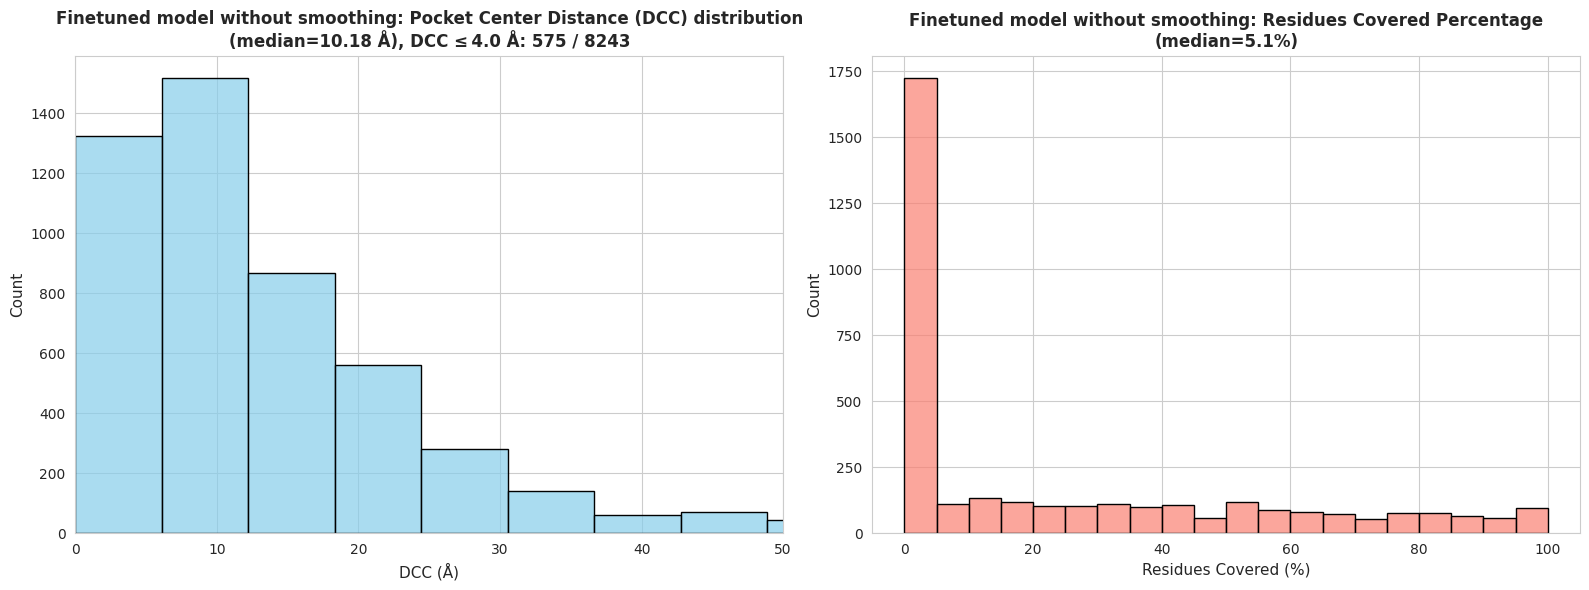

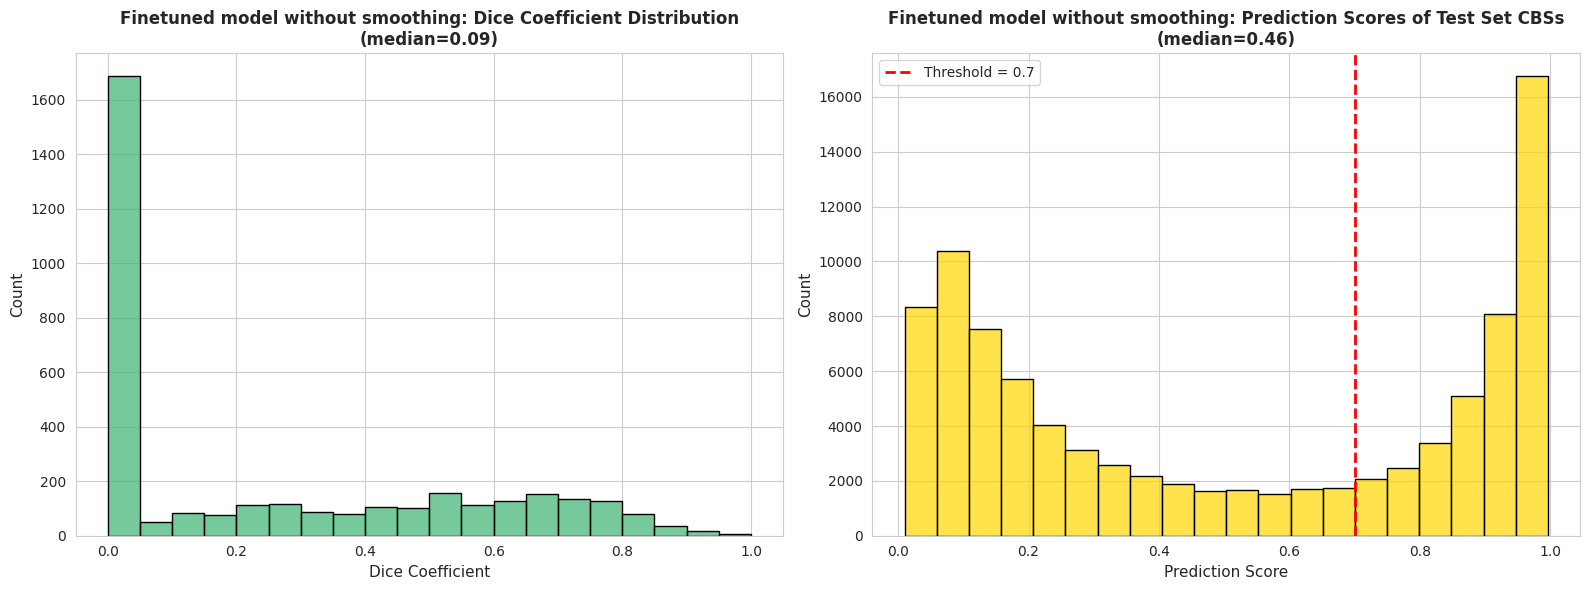

In [16]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model without smoothing'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, no_smoothing_predicted_binding_sites, no_smoothing_prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets, number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=4.0)

# min sapmples = 1, eps=1.7: 0.15528327065388814 0.4827126046342351 8243
# min sapmples = 1, eps=1.7: 0.15528327065388814 0.4827126046342351 8243